In [1]:
using PyPlot
using PyCall
using FITSIO
using Interpolations

@pyimport seaborn as sns
sns.set_context("notebook",font_scale=1.4,rc=Dict("lines.markeredgewidth"=>1))
sns.set_palette("colorblind")
sns.set_style("ticks",Dict("xtick.direction"=>"in","ytick.direction"=>"in"))

@pyimport camb

macro R_str(x) x end

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


@R_str (macro with 1 method)

Parameters of the fiducial model:

In [2]:
Aₛ = exp(3.094)*1e-10
τ = 0.079
nₛ = 0.9645
H₀ = 67.27
h = H₀/100
ωb = 0.02225
ωc = 0.1198

kₚ = 0.05
T₀ = 2.7255;

Here we call CAMB to compute the CMB and matter transfer functions. Note we're computing them at every $\ell$ and at somewhat higher accuracy than normal, so this step may take a few minutes. 

In [3]:
p = camb.set_params(
    As=Aₛ, ns=nₛ, H0=H₀, ombh2=ωb, omch2=ωc, tau=τ, mnu=0.06, 
    pivot_scalar=kₚ, AccuracyBoost=2, lSampleBoost=50, TCMB=T₀, redshifts=[0], kmax=50, lmax=2600
)
r = camb.get_results(p)
t = r[:get_cmb_transfer_data]()
mt = r[:get_matter_transfer_data]();

Next, take the output from CAMB and put it in our matrix `Wkℓ` $\equiv W_\ell(k)$

$$
C_\ell = \int d\ln k \;W_\ell(k) P_*(k)
$$

where $P_*(k)$ is the primordial power spectrum. 

In [4]:
ℓs = 1:2508
ks = t[:q]
dlnk = diff(log(ks))
dlnk = [dlnk[1]; dlnk];

Wkℓ = 4*pi*1e12*T₀^2 * t[:delta_p_l_k][1,:,:].^2 .* t[:l].^2/2/pi
Wkℓ = [zeros(length(ks))'; Wkℓ][ℓs,:];

We can check this is right by doing the sum over $P(k)$ ourselves to verify we get the CMB spectrum back:

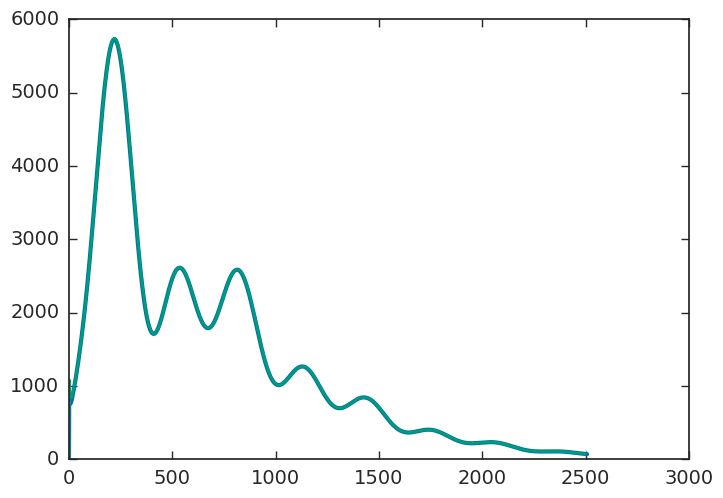

In [5]:
plot(Wkℓ * (Aₛ*(ks/kₚ).^(nₛ-1) .* dlnk),lw=3)
plot(1e12*T₀^2 * r[:get_unlensed_scalar_cls](2500)[:,1])
# xscale("log");

Similarly, the matter transfer functions, such that 
$$P(k) = T(k)^2 P_*(k)$$

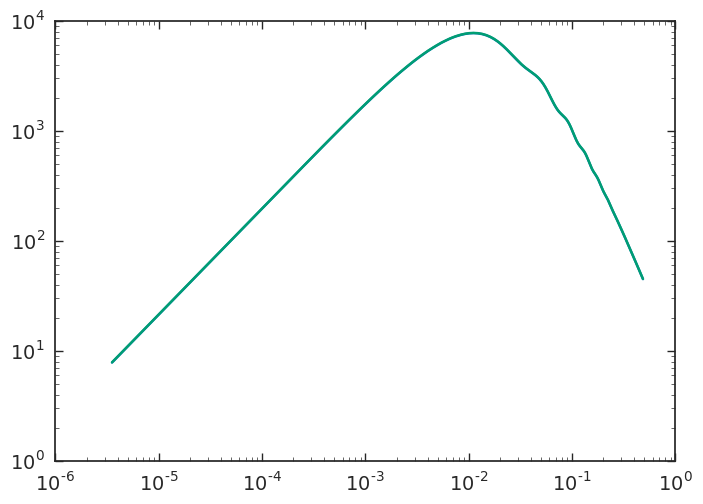

In [6]:
Tk² = interpolate((mt[:q],),mt[:transfer_data][7,:,1].^2 .* mt[:q],Gridded(Linear()))[ks] * 1.82 # <-- why the 1.82? 

mpk = r[:get_linear_matter_power_spectrum]()
mpk = interpolate((mpk[1],),mpk[3][:],Gridded(Linear()));
loglog(ks,Tk² .* (Aₛ*(ks/kₚ).^(nₛ-1)))
loglog(ks,mpk[ks/h]*h^3);

In [7]:
# Planck bins
# lmax=2508
# planck = FITS("COM_PowerSpect_CMB_R2.02.fits")
# lims = zip((read(planck["TTHILBIN"],k) for k=["LMIN","LMAX"])...) |> collect
    
# log spaced
# ledge = map(x->round(Int,x),logspace(log10(2),log10(2500),20))
# lims = collect(zip(ledge[1:end-1],ledge[2:end]-1))#[8:end]
# B = hcat([(r=zeros(lmax); r[l1:l2]=1./(l1:l2); normalize!(r,1)) for (l1,l2)=lims]...);

# Tegmark bins
# lims = [(2, 2), (3, 5), (6, 10), (11, 30), (31, 75), (76, 125), (126, 175), (176, 225), (226, 275), (276, 325), (326, 375), (376, 425), (426, 475), (476, 525), (526, 575), (576, 625), (626, 675), (676, 725), (726, 775), (776, 825), (826, 1000), (1001, 1200), (1201, 1400), (1401, 1600)];
# B = hcat([(r=zeros(lmax); r[l1:l2]=1./(l1:l2); normalize!(r,1)) for (l1,l2)=lims]...);

In [8]:
# load Planck low-L data
f = FITS("COM_PowerSpect_CMB_R2.02.fits")
tocl = 1./((2:29).*((2:29)+1)/2/pi)
d_low = read(f["TTLOLUNB"],"D_ELL").*tocl
σ_low = read(f["TTLOLUNB"],"ERRUP").*tocl
# σ_low = sqrt(read(f["TTLOLUNB"],"ERRUP").*read(f["TTLOLUNB"],"ERRDOWN")).*tocl
close(f)

# load Planck high-L data (Plik-lite)
Σ_high = (open("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/c_matrix_plik_v18.dat") do f
    read(f,Int32) #fortran header
    s = read(f,Float64,(613,613))
    (s+s') - diagm(diag(s))
end)[1:214,1:214];

d_high = readdlm("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v18.dat")[1:214,2]
blmin, blmax = (round(Int,readdlm("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/bl$m.dat")) for m=["min","max"])
bweight = readdlm("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/bweight.dat");
B_high = hcat([(r=zeros(2508); r[(30+lmin):(30+lmax)]=bweight[(1+lmin):(1+lmax)]; r) for (lmin,lmax) in take(zip(blmin,blmax),214)]...);
    
# combine the two    
n_low, n_high = length(d_low), length(d_high)
d_planck = [d_low; d_high]
Σ_planck = [diagm(σ_low.^2) zeros(n_low,n_high); zeros(n_high,n_low) Σ_high]
B = B_planck = [[zeros(1,28); eye(2507,28)] B_high]
    
nbins = size(B_planck,2);

In [9]:
function ebar(Pi)
    cs = cumsum(Pi .* dlnk)
    cs /= cs[end]
    inz = (cs.>0) & (cs.<1)
    itp = interpolate((cs[inz],),ks[inz],Gridded(Linear()))
    itp[[0.2,0.5,0.8]]
end

ebar (generic function with 1 method)

In [10]:
nrebin = [[1, 3, 5, 20]; fill(5,2); fill(10,5); fill(20,7)]
# nrebin = fill(1,214)
lmins = cumsum([1; nrebin])[1:end-1]
lims = zip(lmins,lmins+nrebin-1)
B2 = hcat([(r=zeros(nbins); r[l1:l2]=1; normalize!(r,1)) for (l1,l2)=lims]...);
nbins2 = size(B2,2)

18

In [11]:
tocl = 1./((1:2508).*((1:2508)+1)/2/pi);

In [12]:
σCℓ_over_Cℓ = sqrt(diag(B2'*Σ_planck*B2)) ./ (B2'*d_planck);

In [13]:
Wki = B2'*B'*Wkℓ ./ Tk²';

In [14]:
Pi = Wki ./ sum(Wki .* dlnk',2);

In [15]:
ℓkmap = hcat(map(ebar,(Pi[i,:] for i=1:nbins2))...)';

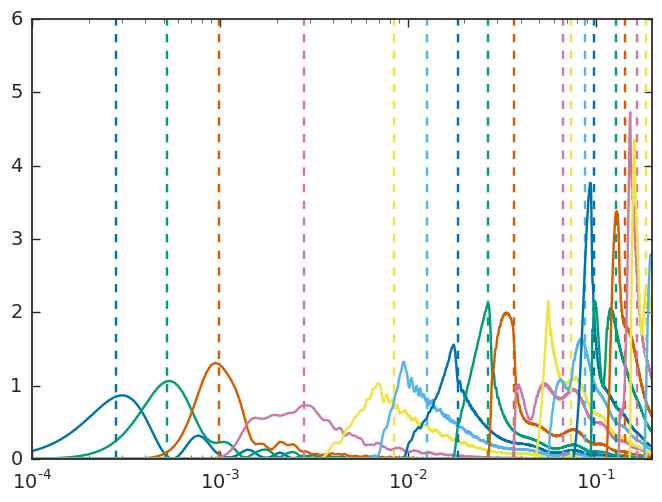

(0.0001,0.2)

In [16]:
# bis = map(x->convert(Int,round(x)),logspace(0,log10(nbins),10))
# bis = [1, 2, 3, 4, 5, 6, 9, 14, 19, 24]
for i=1:nbins2
    l, = semilogx(ks/h,Pi[i,:])
    for j=[2] plot(fill(ℓkmap[i,j],2)/h,[0,6],c=l[:get_color](),j==2?"--":":") end
end
xlim(1e-4,2e-1)

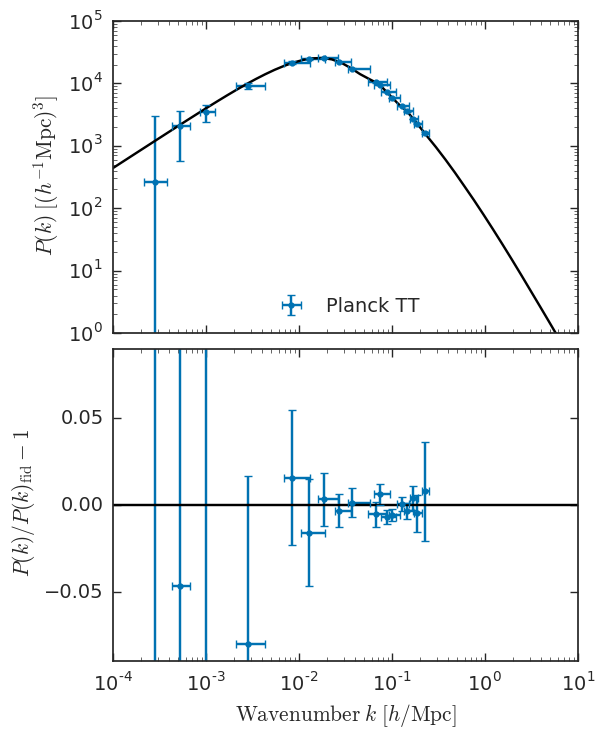

PyObject <matplotlib.text.Text object at 0x7f8b9c532910>

In [18]:
fig=figure(figsize=(6,8))
fig[:subplots_adjust](hspace=0.05)

m = mpk[ℓkmap[:,2]/h]

f_planck = (B2' * d_planck) ./ (B2' * B' * ((1e12*T₀^2 * r[:get_lensed_scalar_cls](2508)[2:end,1]) .* tocl))

ax=subplot(211)

ks′ = logspace(-4,1); plot(ks′,mpk[ks′],"k")

errorbar(
    ℓkmap[:,2]/h, 
    m .* f_planck, 
    yerr=m .* σCℓ_over_Cℓ,
    xerr=abs(ℓkmap[:,[1,3]].-ℓkmap[:,2])',
    marker=".", ls="", 
    label="Planck TT"
)
xscale("log")
yscale("log")
legend(loc="lower center")

xlim(1e-4,10)
ylim(1,1e5)
ax[:set_xticklabels]([])


ylabel(R"$\; P(k) \; [(h^{-1} {\rm Mpc})^3]$")


subplot(212)

plot([1e-4,1e2],fill(0,2),"k")
errorbar(
    ℓkmap[:,2]/h, 
    f_planck - 1,
    yerr=σCℓ_over_Cℓ,
    xerr=abs(ℓkmap[:,[1,3]].-ℓkmap[:,2])',
    marker=".", ls="", 
)
xscale("log")
yscale("linear")

xlim(1e-4,10)
ylim(-0.09,0.09)

xlabel(R"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$")
ylabel(R"$\; P(k)/P(k)_{\rm fid} - 1$")